<a href="https://colab.research.google.com/github/kenwilliford/ML_miscellany/blob/main/heart_disease_prediction_with_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting heart disease with a neural network





## Introduction

This colab notebook builds and trains a neural network model for *binary classification*, when the dataset is *tabular* (rather than unstructured data like images or text) and has a mix of numeric and categorical features. Since tabular datasets are often made available in CSV files, the colab demonstrates the full CSV-to-trained-model workflow.




### The dataset

The dataset ([more background on the data](https://archive.ics.uci.edu/ml/datasets/heart+Disease)) has information on 303 patients, one in each row. Each column (i.e., feature) contains information on a particular attribute of the patient. The column named "Target" indicates if the patient has been diagnosed with heart disease or not and is the label (i.e., the dependent variable) that we want to predict using the other columns.

Feature description (copied from [here](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)):

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Imports


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

## Read in the data

Conveniently, the dataset in CSV form has been made available online (by [Francois Chollet](https://twitter.com/fchollet)) and we can load it into a Pandas dataframe with the very useful `pd.read_csv` command.

In [2]:
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

In [3]:
df.shape

(303, 14)

The dataset has 303 rows and 14 columns (13 independent variables + 1 dependent variable):

Let's take a look at the first few rows:

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


## Preprocessing

This dataset has both categorical variables and numeric variables.

We'd like to preprocess them as follows:
- *one-hot encode* the categorical variables
- *normalize* the numeric variables

It will be convenient (for later processing) to collect these groups of variables into two lists.

In [5]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg','exang', 'ca', 'thal']
numerics = ['age', 'trestbps','chol', 'thalach', 'oldpeak', 'slope']


With the pandas `get_dummies` function, you can one-hot-encode in one line.


In [6]:
df = pd.get_dummies(df, columns = categorical_variables)

In [7]:
df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,63,145,233,150,2.3,3,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,67,160,286,108,1.5,2,1,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,67,120,229,129,2.6,2,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,37,130,250,187,3.5,3,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,41,130,204,172,1.4,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


What % of the data is in the positive class?

In [8]:
df.target.value_counts(normalize=True)

0    0.726073
1    0.273927
Name: target, dtype: float64

In [9]:
y = df.pop('target')


Before we normalize the numerics, let's split the data into an 80% training set and 20% test set.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_X, test_X, train_y, test_y = train_test_split(df, y, test_size=0.2, stratify=y)

Next let's calculate the mean and standard deviation of every numeric variable in the training set.

In [12]:
means = train_X[numerics].mean()
sd = train_X[numerics].std()

In [13]:
means

age          54.698347
trestbps    131.954545
chol        248.921488
thalach     148.504132
oldpeak       1.078099
slope         1.582645
dtype: float64

Let's normalize the train and test dataframes with these means and standard deviations.

In [14]:
train_X[numerics]= (train_X[numerics] - means)/sd

In [15]:
test_X[numerics]= (test_X[numerics] - means)/sd

In [16]:
train_X.head()

,age,trestbps,chol,thalach,oldpeak,slope,sex_0,sex_1,cp_0,cp_1,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
180,2.146720,-0.682081,0.373261,-1.172451,-0.740863,-0.938703,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
99,-0.300109,1.143718,0.912372,1.257355,0.102849,0.672404,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
190,0.700867,0.116706,-0.277391,-0.149375,1.284047,0.672404,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
110,2.480378,-0.396800,1.023913,0.575304,-0.909606,-0.938703,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
116,-2.190840,-0.339744,0.614932,0.319535,-0.909606,-0.938703,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1


The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [17]:
train_X = train_X.to_numpy()
test_X = test_X.to_numpy()

In [18]:
train_X.shape, train_y.shape

((242, 29), (242,))

In [19]:
test_X.shape, test_y.shape


((61, 29), (61,))

## Building the model



### Define model in Keras

Creating a neural network is usually just a few lines of Keras code.

* We will start with a single hidden layer.
* Since this is a *binary classification problem*, we will use a sigmoid activation in the output layer.

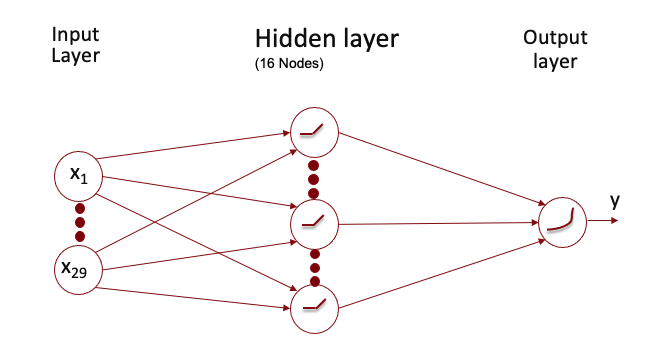

In [61]:
num_columns = train_X.shape[1]

# define the input layer
input = keras.Input(shape=num_columns)

# feed the input vector to the hidden layer
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of the model as defined.

In [62]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 29)]              0         
                                                                 
 Hidden (Dense)              (None, 16)                480       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can "visualize" the network graphically using Keras' `plot_model` function.

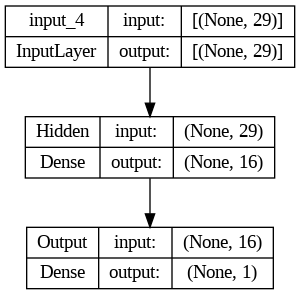

In [63]:
keras.utils.plot_model(model, show_shapes=True)

Let's hand-calculate the number of parameters to verify.

In [64]:
(29 * 16 + 16) + (16 * 1 + 1)

497

### Set optimization parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function.
*   Which **optimizer** to use - we will use a 'flavor' of SGD called **Adam** which is an excellent default choice
*   What **metrics** you want Keras to report out - in classification problems like this one, accuracy is commonly used.

In [65]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## Train the model

To kickoff training, we have to decide on three things:
* The *batch size* - 32 is a good default
* The number of *epochs* i.e., how many passes through the training data. Usually 20-30 epochs is a good starting point but since this dataset is very small, each epoch will be very quick so let's run it for 300 epochs. It will allow us to see if any overfitting happens.
* Whether we want to use a validation set. This will be useful for overfitting detection and regularization via early stopping so we will ask Keras to automatically use 20% of the data points as a validation set.

Let's train the model using the `model.fit` function!

In [66]:
history = model.fit(train_X,
                    train_y,
                    epochs=300,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/300
7/7 [==============================] - 1s 31ms/step - loss: 0.9955 - accuracy: 0.2902 - val_loss: 0.9727 - val_accuracy: 0.3061
Epoch 2/300
7/7 [==============================] - 0s 11ms/step - loss: 0.9405 - accuracy: 0.3005 - val_loss: 0.9278 - val_accuracy: 0.3061
Epoch 3/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8984 - accuracy: 0.2902 - val_loss: 0.8899 - val_accuracy: 0.2653
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8605 - accuracy: 0.2902 - val_loss: 0.8571 - val_accuracy: 0.3061
Epoch 5/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8253 - accuracy: 0.3212 - val_loss: 0.8265 - val_accuracy: 0.3265
Epoch 6/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7945 - accuracy: 0.3575 - val_loss: 0.7978 - val_accuracy: 0.3878
Epoch 7/300
7/7 [==============================] - 0s 8ms/step - loss: 0.7671 - accuracy: 0.3990 - val_loss: 0.7742 - val_accuracy: 0.4286
Epoch 8/300
7/7 [========

Next we plot the training and loss curves to see if ***overfitting*** is going on and if **early stopping** may be needed.

In [67]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

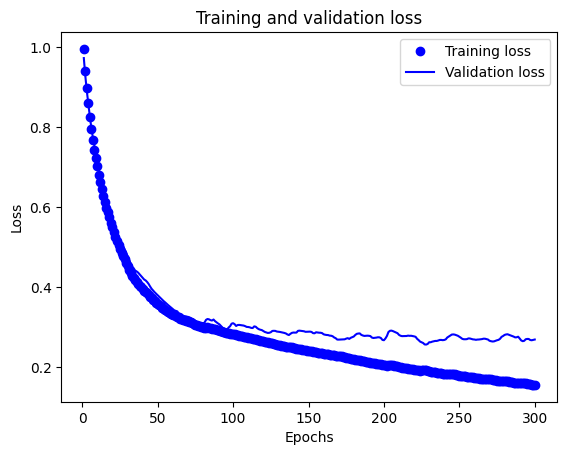

In [68]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Let's look at the accuracy curves as well.



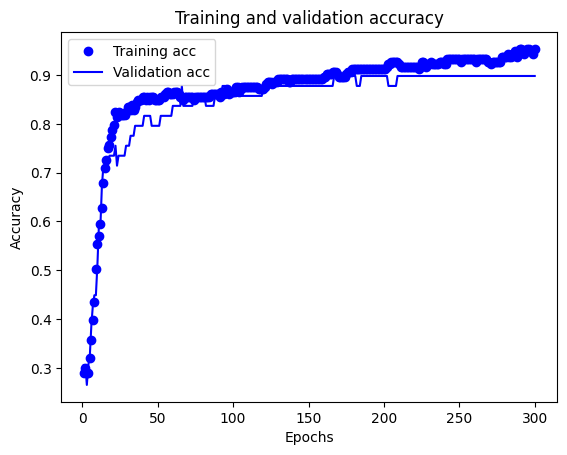

In [69]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**There is some indication of overfitting.**

The divergence between training and validation loss and accuracy prior to 300 epochs indicate some degree of overfitting. We could go back, re-initialize the model and train for fewer epochs as an example of **early stopping**.

Before doing that, let's evaluate the model performance in its current form.

## Evaluate the model

Let's see **how well the model does on the test set**.

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [70]:
model.evaluate(test_X, test_y)

2/2 [==============================] - 0s 11ms/step - loss: 0.4098 - accuracy: 0.8361


[0.40976500511169434, 0.8360655903816223]

To assess if this accuracy number is impressive, we can compare it the accuracy of a simple, baseline model.

What's a reasonable baseline model?

In [71]:
y.value_counts(normalize=True)

0    0.726073
1    0.273927
Name: target, dtype: float64

If we predict 0 for every point, the accuracy will be 72.6%. So the 83.6% accuracy from our model is a substantial improvement!


## Predicting new data (i.e., *inference*) with the model

The simple approach we followed in this colab has a key shortcoming. We did the pre-processing - the one-hot encoding and normalization - *outside* the model. This means that we have to remember what pre-processing we did and carry that information (e.g., the mean and variance of each variable) along with the model to correctly use the model in the future.

An elegant way to avoid this issue is to use [Keras preprocessing layers](https://keras.io/guides/preprocessing_layers/). Check out this [colab](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/structured_data/ipynb/structured_data_classification_from_scratch.ipynb) which shows how to solve the same heart-disease prediction problem above using preprocessing layers.
